# Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

-Create a Jupyter Notebook file called climate_analysis.ipynb and use it to complete your climate analysis and data exporation.

-Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
-Use SQLAlchemy create_engine to connect to your sqlite database.

-Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.

In [ ]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.sql import func
from sqlalchemy.sql import label
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
import datetime as dt
import pandas as pd
from pandas import DataFrame

In [2]:
# Create engine & connection
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn = engine.connect()

In [3]:
# Create automap
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# Assign the measurement and station classes to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
#create a session
session = Session(engine)

# Precipitation Analysis

-Design a query to retrieve the last 12 months of precipitation data.

-Select only the date and prcp values.

-Load the query results into a Pandas DataFrame and set the index to the date column.

-Plot the results using the DataFrame plot method.

-Use Pandas to print the summary statistics for the precipitation data.

In [6]:
# Find the last year's precipitation data
query = session.query(Measurement.date, func.sum(Measurement.prcp)).group_by(Measurement.date).\
    order_by(Measurement.id.desc()).limit(365).all()

In [7]:
# Convert query into a DF and invert the dates
prc_df = pd.DataFrame(query, columns=['Date', 'Precipitation'])
prc_df = prc_df.sort_index(ascending=False)
prc_df = prc_df.reset_index()
prc_df = prc_df.drop("index", 1)
prc_df.head()

,Date,Precipitation
0,8/7/16,6.68
1,8/8/16,1.32
2,8/9/16,1.18
3,8/10/16,0.00
4,8/11/16,0.18


In [8]:
# Find label names for every 50 days to plot at reference for graph
import numpy as np
ticks = np.arange(0, 400, 50)
ticks = ticks.tolist()
ticks

date_tick = []
for x in ticks:
    date = prc_df["Date"][x]
    date_tick.append(date)
    
date_tick

['8/7/16',
 '9/27/16',
 '11/16/16',
 '1/8/17',
 '3/1/17',
 '4/24/17',
 '6/19/17',
 '8/9/17']

In [9]:
# Reset DF index
prc_df = prc_df.set_index('Date')

In [10]:
prc_df.describe()

,Precipitation
count,365.000000
mean,2.053589
std,3.589261
min,0.000000
25%,0.120000
50%,0.880000
75%,2.300000
max,28.560000


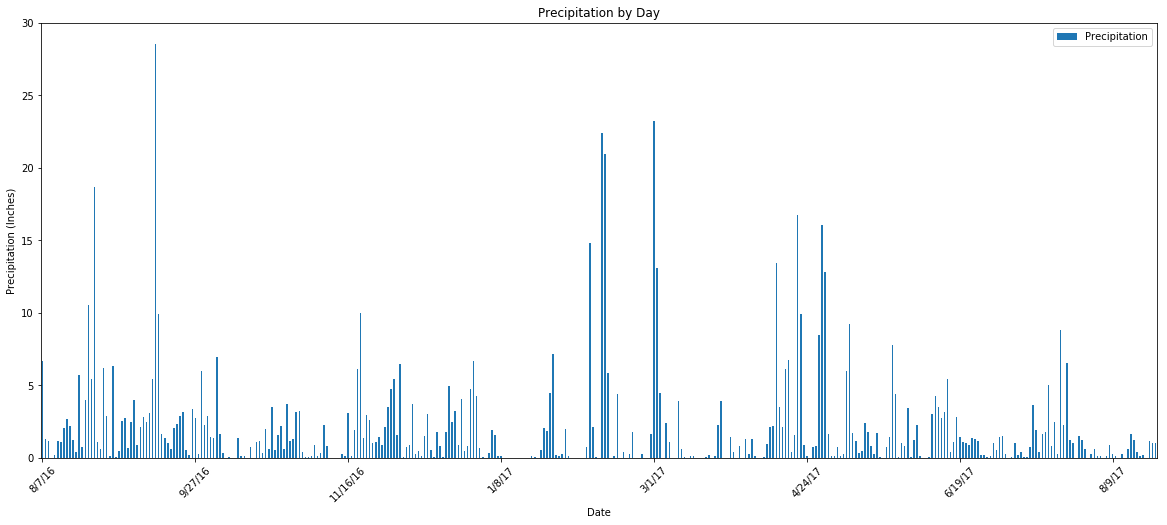

In [11]:
# Plot the DF
prc_df.plot(kind="bar", figsize=(20,8))
plt.xticks(ticks, date_tick, rotation=45)
plt.title("Precipitation by Day")
plt.ylabel("Precipitation (Inches)")
#plt.savefig("Figures/Precipitation_by_day")
plt.show()

# Station Analysis

-Design a query to calculate the total number of stations.

-Design a query to find the most active stations.

-List the stations and observation counts in descending order

-Which station has the highest number of observations?

-Design a query to retrieve the last 12 months of temperature observation data (tobs).

-Filter by the station with the highest number of observations.

-Plot the results as a histogram with bins=12.

In [12]:
# Design a query to calculate the total number of stations.
from sqlalchemy import distinct
number_of_stations = session.query(func.count(distinct(Measurement.station))).scalar()
print(f'The total number of stations : {number_of_stations}')

The total number of stations : 9


In [13]:
# Station Activity
Station_Activity = session.query(Station.station, Station.name, func.count(Measurement.date)). \
    filter(Station.station == Measurement.station).\
    group_by(Station.name).order_by(func.count(Measurement.date).desc()).all()

Station_Activity

[('USC00519281', 'WAIHEE 837.5, HI US', 16632),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 16344),
 ('USC00513117', 'KANEOHE 838.1, HI US', 16254),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 16014),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 15672),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 13212),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 11874),
 ('USC00517948', 'PEARL CITY, HI US', 8232),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 3066)]

In [14]:
highest = "USC00519281"

high_tobs = session.query(Measurement.date, Measurement.tobs).order_by(Measurement.id.desc()). \
    filter(Measurement.station == highest).limit(365).all()
    
#high_tobs

In [15]:
# Convert query into a DF
tobs = pd.DataFrame(high_tobs, columns=["Date", "Temp Obs"])
tobs.head()

,Date,Temp Obs
0,8/18/17,79.0
1,8/17/17,76.0
2,8/16/17,76.0
3,8/15/17,77.0
4,8/14/17,77.0


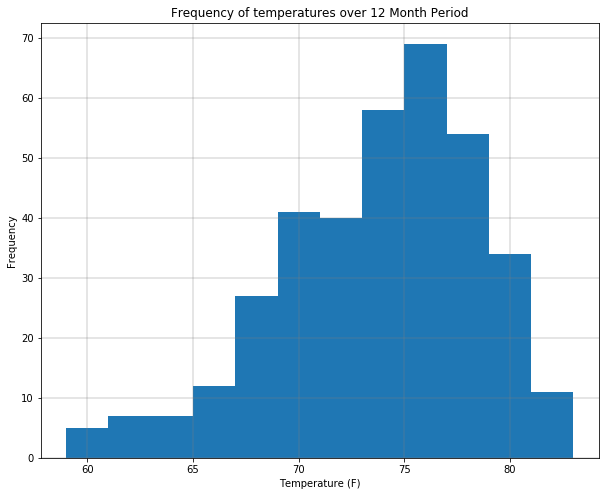

In [16]:
plt.figure(figsize=(10,8))
plt.hist(tobs["Temp Obs"], bins=12)
plt.grid(color='grey', linestyle='-', linewidth=2, alpha=.2)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Frequency of temperatures over 12 Month Period")
 
plt.show()

# Temperature Analysis


-Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

- Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

- Plot the min, avg, and max temperature from your previous query as a bar chart.

  -Use the average temperature as the bar height.

  -Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [17]:
def calc_temps(start_date, end_date):
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date > start_date).\
    filter(Measurement.date < end_date)
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date > start_date).\
    filter(Measurement.date < end_date)
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date > start_date).\
    filter(Measurement.date < end_date)
    return min_temp, avg_temp, max_temp

    

In [27]:
min_temp, avg_temp, max_temp = calc_temps("2017-04-05", "2017-04-15")

['2016-04-05', '2016-04-15']


/anaconda3/envs/PythonData_2/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/PythonData_2/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: max() arg is an empty sequence

In [4]:
def calc_temps (start_date, end_date):
    
    # Converting to date time
    startDate = dt.dt.strptime(start_date, "%Y-%m-%d")
    startDate = startDate.replace(startDate.year - 1)
    endDate = dt.dt.strptime(end_date, "%Y-%m-%d")
    endDate = endDate.replace(endDate.year - 1)
   
    
    # Getting date range
    delta = endDate - startDate
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(startDate + timedelta(days=i))
        
    # Converting to strings to filter
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
        
    # Grabbing avg, min & max temps    
    temp_avg = session.query(func.avg(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
        
    return temp_avg, temp_min, temp_max


In [5]:

# Calling function
temp_analysis = calc_temps("2016-05-06", "2016-05-12")

# Creating variables
tavg = temp_analysis[0]
tmin = temp_analysis[1]
tmax = temp_analysis[2]

# Plotting bar
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_analysis.png")
plt.show()

NameError: name 'dt' is not defined